In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Counterfactual explanation for Mobile Price Classification dataset

TODO: explain the task and something about counterfactual explanation.


## Installation and import of the needed libraries


### Installation (mandatory on Colab)

First of all we clone the Github repository in order to have all the needed files to perform our analysis.

This is needed only if the current notebook isn't executed directly from the repository folder (e.g. Google Colab)


In [116]:
# !mkdir my_repo
# !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo


Run the following cell only if the current working directory is not the repository.


In [117]:
# %cd my_repo


Then we can install all the libraries from the `requirements.txt` file.


In [118]:
# !pip install -r requirements.txt -q


- OMLT, version 1.1
- ONNX, version 1.12.0. A newer version is available (1.13.1) but it gives conflict error with TensorFlow. If the latter isn't needed, then the installed version can be upgraded.


### Import and configuration setup


In [119]:
# python modules
import configparser
import os
import re

# 3rd party modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import cross_val_score

# user modules
from utils import util_data, util_preprocess, util_plot, util_models


In order to manage the randomness we wrote the following cell to make the experiments reproducible, check the following [link](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

A numpy Random Generator object is constructed for controlling randomness: necessary for robust results in estimator performance with cross-validation.


In [120]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)


Moreover we import the configuration file to have all the parameters along the notebook.


In [121]:
pd.set_option("max_colwidth", 800)


In [122]:
config = configparser.ConfigParser()
config.read("config.ini")


['config.ini']

## Dataset exploration and preprocessing

For the project we use the following dataset from Kaggle: [dataset](https://www.kaggle.com/datasets/msainani/gsmarena-mobile-devices).

It gives information about different characteristics of the smartphones (e.g. RAM, cores, ...) and the target variable is the price range of the device. The list has been scraped from the known website [GSMArena](gsmarena.com).


In [123]:
ds_conf = config["GSMARENA_DS"]
# Download the training and test datasets
download_helper = util_data.DownloadHelper(
    ds_conf["url"], ds_conf["name"], ds_conf["mode"], quiet=False
)

download_helper.download()


File gsm.csv already exists. Skip download.


After that we downloaded the dataset we can load it as a dataframe to leverage Pandas built-in functions.


In [124]:
df_raw = download_helper.read_csv(low_memory=False, sep=",", dtype="string")


### Preliminary exploration for preprocessing

The dataset has 10679 samples, each with 86 features. However, only some of the features are necessary for the task, so we can remove the others.

All the columns are text data, hence are in the _StringDtype_ type.


In [125]:
df_raw.head(3)


,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,main_camera_dual_or_triple,battery_music_play,selfie_camera_triple,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by
0,Benefon,Vega,GSM,GSM 900,No,No,1999,Discontinued,145 x 56 x 23 mm (5.71 x 2.20 x 0.91 in),190 g (6.70 oz),...,<NA>,<NA>,<NA>,<NA>,<NA>,No,<NA>,<NA>,4 - 10 h,3 - 6 days
1,Garmin-Asus,nuvifone M10,GSM / HSPA,GSM 900 / 1800 / 1900,<NA>,<NA>,"2010, January. Released 2010, March",Discontinued,-,-,...,<NA>,<NA>,<NA>,<NA>,V2,<NA>,<NA>,GSM 850 / 1800 / 1900 - US version,Up to 8 h,Up to 600 h (2G) / Up to 600 h (3G)
2,Gigabyte,GSmart G1305 Boston,GSM / HSPA,GSM 850 / 900 / 1800 / 1900,<NA>,<NA>,"2010, April. Released 2010, April",Discontinued,116 x 56.8 x 12.4 mm (4.57 x 2.24 x 0.49 in),118 g (4.16 oz),...,<NA>,<NA>,<NA>,<NA>,V2,<NA>,<NA>,<NA>,Up to 7 h 10 min,Up to 410 h


In [126]:
print(f"Number of rows: {df_raw.shape[0]}")


Number of rows: 10679


In [127]:
print(f"Number of columns: {df_raw.shape[1]}")
print(df_raw.columns)


Number of columns: 86
Index(['oem', 'model', 'network_technology', 'network_2g_bands',
       'network_gprs', 'network_edge', 'launch_announced', 'launch_status',
       'body_dimensions', 'body_weight', 'body_sim', 'display_type',
       'display_size', 'display_resolution', 'display', 'memory_card_slot',
       'memory_phonebook', 'memory_call_records', 'sound_loudspeaker',
       'sound_alert_types', 'sound_3.5mm_jack', 'comms_wlan',
       'comms_bluetooth', 'comms_gps', 'comms_radio', 'comms_usb',
       'features_sensors', 'features_messaging', 'features_browser',
       'features_clock', 'features_alarm', 'features_games', 'features_java',
       'features', 'misc_colors', 'network_3g_bands', 'network_speed',
       'platform_os', 'platform_chipset', 'platform_cpu', 'platform_gpu',
       'memory_internal', 'main_camera_single', 'main_camera_video',
       'misc_price', 'main_camera_features', 'body', 'network_4g_bands',
       'body_build', 'display_protection', 'memory', 'main

In [128]:
df_raw.dtypes.value_counts()


string    86
dtype: int64

### Explore relevant features


- _misc_price_: label for the classification
- _launch_announced_: year of the announcement
- _network_technology_: 2G, 3G, 4G, 5G
- **Float features**: display_size, battery
- **Binary features**: display_type, memory_card_slot, sound_loudspeaker, sound_3.5mm_jack, comms_wlan, comms_nfc, battery_charging, body
- **Multi column features**: display_resolution, memory_internal
- **Camera features**: main_camera, selfie_camera


In [129]:
df_copy = df_raw.copy()


#### Explore the launch_announced column


There are 91 values which are NaN. However, these samples belongs to two distinct categories:

- 82 samples don't have any price, so without a proper label they must be dropped.
- 9 samples have a price, but carefully looking at the "launch_status", only two of them have been "discontinued", while the remaining ones have been "cancelled".

Nonetheless, these 91 samples can be easily dropped, because only for 2 of them the launch year could be found, but a quick online search doesn't provide any results.


In [130]:
# pattern to extract year from launch_announced
pat_year = r"([\d]{4})"
# launch_announced series
ser_year = df_copy["launch_announced"]

ser_year = util_preprocess.DataTransformer.process_float_feature(ser_year, pat_year)


In [131]:
df_copy.loc[ser_year[ser_year.isna()].index][
    ["oem", "model", "launch_announced", "launch_status", "misc_price"]
].dropna(subset="misc_price")


,oem,model,launch_announced,launch_status,misc_price
853,Xiaomi,Mi Max 4,Not announced yet,Cancelled,About 300 EUR
854,Xiaomi,Mi Max 4 Pro,Not announced yet,Cancelled,About 350 EUR
1642,Coolpad,3632,Not announced yet,Cancelled,About 100 EUR
2610,Asus,Z801,V1,Discontinued,About 260 EUR
4920,Lenovo,ideapad,V1,Cancelled,About 130 EUR
5589,Meizu,PRO 5 mini,Not announced yet,Cancelled,About 360 EUR
8982,Samsung,Galaxy On5 (2016),Not announced yet,Cancelled,About 220 EUR
10070,Vodafone,830i,V1,Discontinued,About 170 EUR
10244,Xiaomi,Redmi Pro 2,Not announced yet,Cancelled,About 210 EUR


#### Explore the misc_price column


There are only 6537 valid price rows. For most of the models the currency available is EURO, but for the others a suitable conversion rate should be found to estimate the actual price in EURO. This could be difficult due to different [purchasing power parities](https://data.oecd.org/conversion/purchasing-power-parities-ppp.htm) and the region market (Europe, India, USA), but after some observations they are estimated as follows:

- INR -> EUR: a linear regression model is fitted on some of the available data to find the conversion rate. A comparison with the median rate and an [average rate retrieved online](https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-inr.en.html) shows that the one estimated is the most accurate.
- USD -> EUR: some prices are outliers, i.e. shows a conversion rate too much higher or smaller that a "real" rate (e.g. 0.40 or 2), for this reason even a linear regression isn't suitable because too much sensible to these values in the training dataset. The best result is achieved with the Huber regressor.
- GBP -> EUR: few samples are available to estimate the price, so the only way to compute the price in EURO is to use the [online rate](https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-gbp.en.html).


In [132]:
misc_price = df_copy["misc_price"]
to_replace = {
    "<e2><80><89>": " ",
    "<e2><82><ac>": "EUR",
    "<e2><82><B9>": "INR",
    "<c2><a3>": "GBP",
    "€": "EUR",
    "\$": "USD",
    "£": "GBP",
    "\u2009": " ",
    "(,)(?=[\d]{3})": "",
}
for k, v in to_replace.items():
    misc_price = misc_price.str.replace(k, v, regex=True, flags=re.IGNORECASE)

print(f"Number of valid 'misc_price' rows: {misc_price.count()}")


Number of valid 'misc_price' rows: 6537


Conversion rate between INR and EUR


Number of prices: 40
Year coverage: [2020. 2019.]


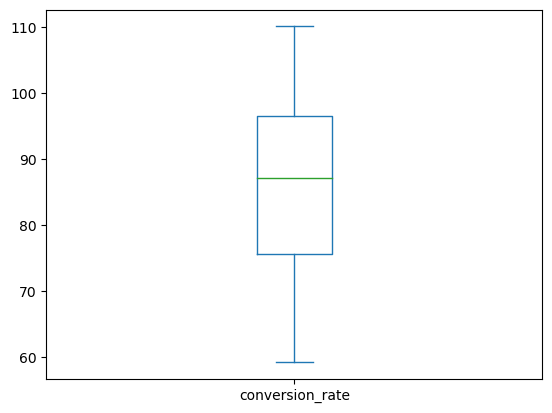

In [133]:
curr = "INR"
prices_ext, conversion_rate = util_preprocess.extract_prices_rate(curr, misc_price)

# add the year to the conversion rate
conv_rate_year = pd.concat(
    [conversion_rate, ser_year.loc[conversion_rate.index]], axis=1
).sort_values("conversion_rate")
print(f"Year coverage: {conv_rate_year['launch_announced'].unique()}")

conversion_rate.plot.box(whis=1.5)
plt.show()


A small standard deviation for the estimator and the absence of outliers denotes that the price pairs can be correctly estimated by a linear regressor.


In [134]:
X, y = prices_ext["eur"].values.reshape(-1, 1), prices_ext[curr.lower()].values
idx = rng.permutation(X.shape[0])
X, y = X[idx], y[idx]

model_fit = LinearRegression(fit_intercept=False)

scores = -cross_val_score(model_fit, X, y, cv=5, scoring="neg_mean_absolute_error")
pd.Series(scores).describe()


count       5.000000
mean     4233.090677
std      1657.635088
min      1633.052276
25%      3642.445812
50%      4727.625527
75%      5543.865809
max      5618.463961
dtype: float64

median coefficients: [87.04712214]
median RMSE: 5987.55
median r2-score: 0.84
median MAE: 4848.74

linear regressor coefficients: [93.25124029]
linear regressor RMSE: 8413.92
linear regressor r2-score: 0.69
linear regressor MAE: 6830.64

online_rate coefficients: [81.749]
online_rate RMSE: 4033.19
online_rate r2-score: 0.93
online_rate MAE: 3354.65



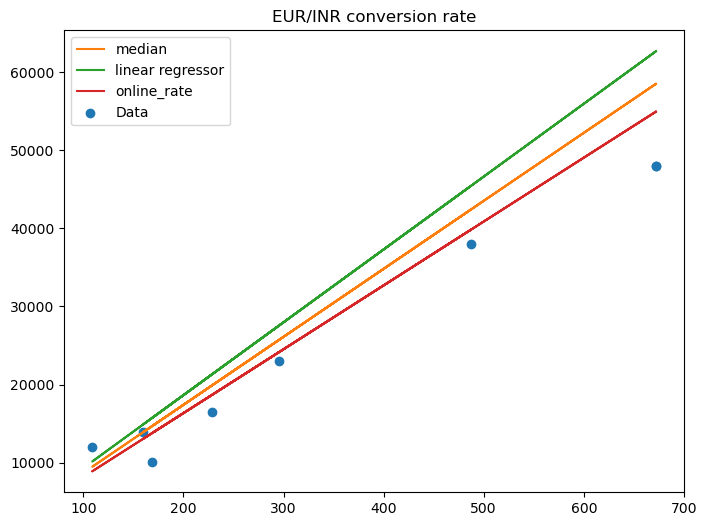

In [135]:
X, y = prices_ext["eur"].values.reshape(-1, 1), prices_ext[curr.lower()].values

model_median = util_models.FixedLinearRegressor(
    conversion_rate.median(), fit_intercept=False
)
model_linear = LinearRegression(fit_intercept=False)
model_rate = util_models.FixedLinearRegressor(81.749, fit_intercept=False)

models = [model_median, model_linear, model_rate]
names = ["median", "linear regressor", "online_rate"]
X_test, y_test, y_preds = util_models.compare_models(X, y, models, names, rng=rng)

# plot the data
util_plot.plot_compare_models(
    X_test, y_test, y_preds, names, f"EUR/{curr} conversion rate"
)


Conversion rate between USD and EUR


Number of prices: 164
Year coverage: [2019. 2020. 2018.]


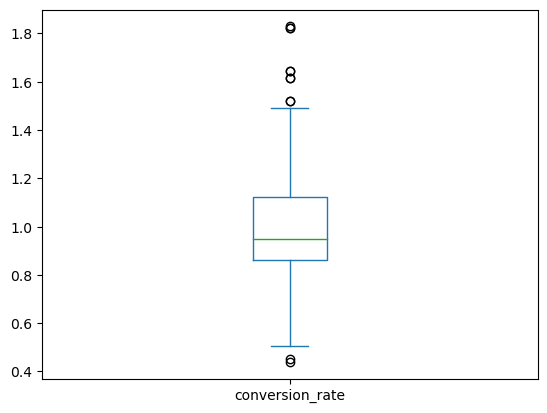

In [136]:
curr = "USD"
prices_ext, conversion_rate = util_preprocess.extract_prices_rate(curr, misc_price)

# add the year to the conversion rate
conv_rate_year = pd.concat(
    [conversion_rate, ser_year.loc[conversion_rate.index]], axis=1
).sort_values("conversion_rate")
print(f"Year coverage: {conv_rate_year['launch_announced'].unique()}")

conversion_rate.plot.box(whis=1.5)
plt.show()


The presence of some outliers denotes that a linear regression model might not fit correctly some prices, because the training process could be drifted by "outlier" conversion rates.

It's better to estimate the prices with a regression less sensible to outliers, i.e. the Huber Regressor.


In [137]:
df_concat = pd.concat([conversion_rate, prices_ext.loc[conversion_rate.index]], axis=1)
util_data.compute_outlier(df_concat, "conversion_rate")


Lower bound: 0.47
Upper bound: 1.52
Number of outliers: 11


,conversion_rate,eur,usd
1278,1.518330,92.20,139.99
395,1.518330,92.20,139.99
447,1.821494,279.99,510.00
1330,1.821494,279.99,510.00
1311,1.643097,419.33,689.00
428,1.643097,419.33,689.00
426,1.615594,587.40,949.00
1309,1.615594,587.40,949.00
1493,0.437331,997.14,436.08
1567,0.452106,1172.27,529.99


median coefficients: [0.94851752]
median RMSE: 120.91
median r2-score: 0.72
median MAE: 60.96

linear regressor coefficients: [0.91135179]
linear regressor RMSE: 117.03
linear regressor r2-score: 0.74
linear regressor MAE: 60.84

online_rate coefficients: [0.92]
online_rate RMSE: 117.77
online_rate r2-score: 0.73
online_rate MAE: 60.52



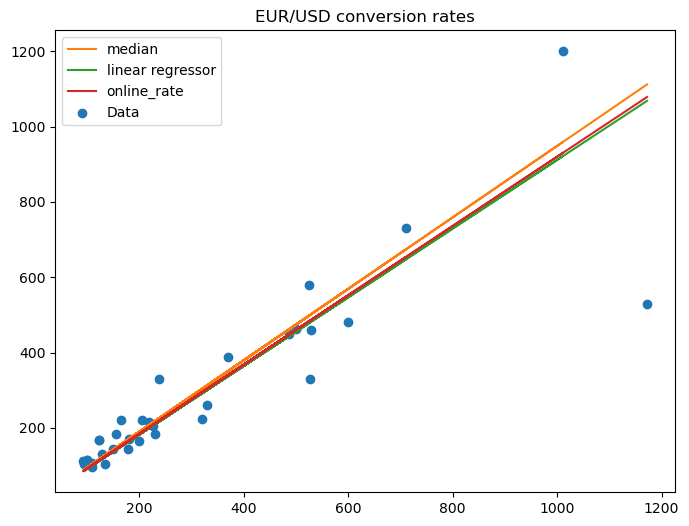

In [138]:
X, y = prices_ext["eur"].values.reshape(-1, 1), prices_ext[curr.lower()].values

model_median = util_models.FixedLinearRegressor(
    conversion_rate.median(), fit_intercept=False
)
model_fit = HuberRegressor(fit_intercept=False, tol=1e-7, alpha=0.2, epsilon=1.1)
model_rate = util_models.FixedLinearRegressor(1.14 - 0.22, fit_intercept=False)

models = [model_median, model_fit, model_rate]
names = ["median", "linear regressor", "online_rate"]
X_test, y_test, y_preds = util_models.compare_models(X, y, models, names, rng=rng)

# plot the data
util_plot.plot_compare_models(
    X_test, y_test, y_preds, names, f"EUR/{curr} conversion rates"
)


Conversion rate between GBP and EUR


Number of prices: 3
Year coverage: [2020.]


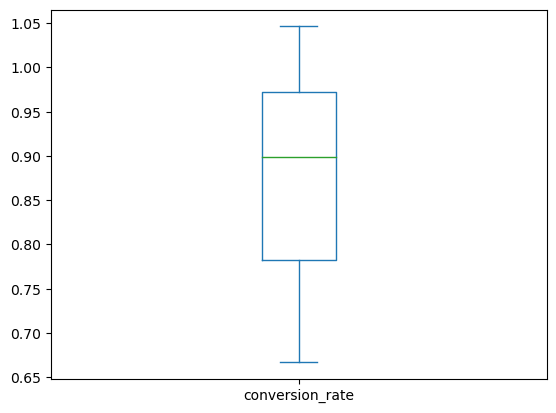

In [139]:
curr = "GBP"
prices_ext, conversion_rate = util_preprocess.extract_prices_rate(curr, misc_price)

# add the year to the conversion rate
conv_rate_year = pd.concat(
    [conversion_rate, ser_year.loc[conversion_rate.index]], axis=1
).sort_values("conversion_rate")
print(f"Year coverage: {conv_rate_year['launch_announced'].unique()}")

conversion_rate.plot.box(whis=1.5)
plt.show()


median coefficients: [0.89913915]
median RMSE: 21.68
median r2-score: -1.43
median MAE: 16.27

online_rate coefficients: [0.8897]
online_rate RMSE: 21.13
online_rate r2-score: -1.31
online_rate MAE: 16.34



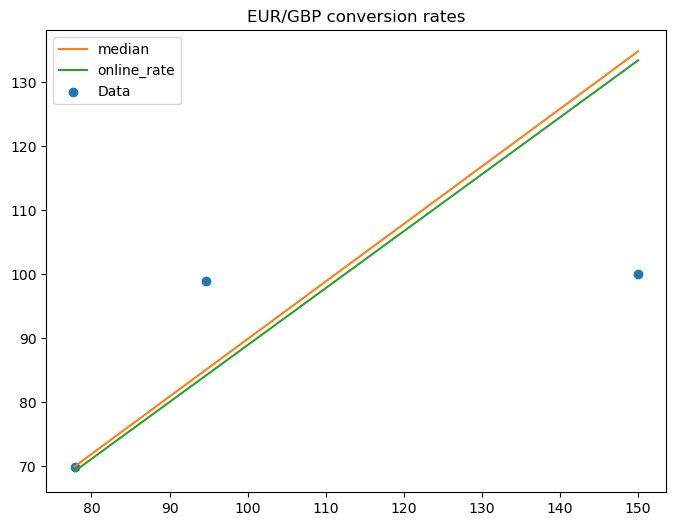

In [140]:
X, y = prices_ext["eur"].values.reshape(-1, 1), prices_ext[curr.lower()].values

model_median = util_models.FixedLinearRegressor(
    conversion_rate.median(), fit_intercept=False
)
model_rate = util_models.FixedLinearRegressor(0.88970, fit_intercept=False)

models = [model_median, model_rate]
names = ["median", "online_rate"]
X_test, y_test, y_preds = util_models.compare_models(X, y, models, names, rng=rng)

# plot the data
util_plot.plot_compare_models(
    X_test, y_test, y_preds, names, f"EUR/{curr} conversion rates"
)


#### Float features: display_size and battery

- display_size: contains the display in inches.
- battery: contains the battery capacity in mAh.


In [141]:
df_copy.loc[0:5, ["display_size", "battery"]]


,display_size,battery
0,<NA>,Removable Li-Ion battery
1,"3.5 inches, 34.9 cm",Removable Li-Ion 1500 mAh battery
2,"3.2 inches, 30.5 cm (~46.3% screen-to-body ratio)",Removable Li-Po 1230 mAh battery
3,"2.8 inches, 24.3 cm (~43.7% screen-to-body ratio)",Removable Li-Ion 1500 mAh battery
4,"6.3 inches, 98.0 cm (~81.3% screen-to-body ratio)",Non-removable Li-Po 3700 mAh battery
5,"5.7 inches, 80.7 cm (~79.8% screen-to-body ratio)",Non-removable Li-Po 2800 mAh battery


#### Binary features

- display_type: extract whether the display is OLED or LCD
- memory_card_slot: the device contains a slot for a microSD is contained
- sound_loudspeaker: the speaker is stereo or mono
- sound_3.5mm_jack: the device has a 3.5mm jack
- comms_wlan: the technology of the wlan chipset, i.e. 2.4GHz or 5Ghz
- comms_nfc: the device supports the nfc
- battery_charging: extract whether the device has support for fast-charging
- body: extract whether the device is waterproof

For some of these features (display_type, comms_wlan, battery_charging, body) each feature is changed from the original one to extract more relevant information about the devices.


The "display_type" feature contains the keyword OLED, which depicts different display device technology, such as P-OLED, AMOLED or Super Retina. Otherwise the feature corresponds to a LCD display technology.


In [142]:
df_copy.loc[0:5, ["display_type"]]


,display_type
0,Monochrome graphic
1,"TFT resistive touchscreen, 65K colors"
2,"TFT capacitive touchscreen, 256K colors"
3,"TFT capacitive touchscreen, 256K colors"
4,"P-OLED capacitive touchscreen, 16M colors"
5,"P-OLED capacitive touchscreen, 16M colors"


The "comms_wlan" feature contains the different [IEEE 802.11 standard](https://en.wikipedia.org/wiki/IEEE_802.11) supported. To distinguish whether the device supports the 5GHz or only the 2.4GHz depends on the standard adopted: the former is supported if at least one of "a" or "ac" generations is present in the feature.


In [143]:
df_copy.loc[0:5, ["comms_wlan"]]


,comms_wlan
0,No
1,Wi-Fi 802.11b/g
2,Wi-Fi 802.11 b/g
3,Wi-Fi 802.11 b/g
4,"Wi-Fi 802.11 a/b/g/n/ac, dual-band, Wi-Fi Direct, DLNA, hotspot"
5,"Wi-Fi 802.11 a/b/g/n/ac, dual-band, Wi-Fi Direct, DLNA, hotspot"


When the "battery_charging" feature contains the keyword wireless the device supports any type of wireless charging (QI, Power Delivery), otherwise only a wired charging is possible.


In [144]:
df_copy.loc[0:5, ["battery_charging"]]


,battery_charging
0,<NA>
1,<NA>
2,<NA>
3,<NA>
4,Fast charging 18W USB Power Delivery 2.0 QI wireless charging
5,Fast charging 18W USB Power Delivery 2.0 QI wireless charging


The "body" feature might contain the keywords "IP6x", "splash" or "water" when the device is waterproof, a characteristic important for expensive devices.


In [145]:
df_copy.loc[0:5, ["body"]]


,body
0,<NA>
1,<NA>
2,<NA>
3,Trackball
4,IP68 dust/water resistant (up to 1.5m for 30 mins)
5,IP68 dust/water resistant (up to 1.5m for 30 mins)


The remaining binary features usually contains the word "Yes" to describe the presence of the feature or in some case they explictly mention the feature.


In [146]:
df_copy.loc[
    0:5, ["memory_card_slot", "sound_loudspeaker", "sound_3.5mm_jack", "comms_nfc"]
]


,memory_card_slot,sound_loudspeaker,sound_3.5mm_jack,comms_nfc
0,No,No,No,<NA>
1,microSDHC (dedicated slot),Yes,Yes,<NA>
2,microSDHC (dedicated slot),Yes,Yes,<NA>
3,microSDHC (dedicated slot),Yes,Yes,<NA>
4,No,"Yes, with stereo speakers",No,Yes
5,No,"Yes, with stereo speakers",No,Yes


#### Multi column features: display_resolution and memory_internal

- display_resolution: contains the resolution of the display in pixels, both for the width and the height. If at least one of the two values is smaller than 1000, then the value is dropped because it's too small to be a smartphone display. Pheraps it could be a smartwatch display or an old smartphone.
- memory_internal: contains the internal memory of the device in GB, both for the RAM and the ROM. When the device has at least one capacity expressed in MB, then the value is dropped because it's too small to be relevant.


In [147]:
df_copy.loc[0:5, ["display_resolution", "memory_internal"]]


,display_resolution,memory_internal
0,6 lines,<NA>
1,"480 x 800 pixels, 5:3 ratio (~267 ppi density)",4GB 512MB RAM
2,"320 x 480 pixels, 3:2 ratio (~180 ppi density)",256MB RAM
3,"240 x 320 pixels, 4:3 ratio (~143 ppi density)","256MB RAM, 512MB"
4,"1440 x 3040 pixels, 19:9 ratio (~537 ppi density)","64GB 6GB RAM, 128GB 6GB RAM"
5,"1080 x 2280 pixels, 19:9 ratio (~444 ppi density)","64GB 6GB RAM, 128GB 6GB RAM"


#### Network technology

The "network_technology" feature contains the different network technologies supported by the device. The most important ones are:

- 5G: the device supports the 5G network
- 4G: the device supports the 4G network, usually described as LTE.
- 3G: the device supports the 3G network, usually described as UMTS or HSPA.

The other technologies are less important, such as GSM, CDMA, EVDO or even devices with no network support are dropped.


In [148]:
df_copy.loc[0:5, "network_technology"]


0                               GSM
1                        GSM / HSPA
2                        GSM / HSPA
3                        GSM / HSPA
4    GSM / CDMA / HSPA / EVDO / LTE
5    GSM / CDMA / HSPA / EVDO / LTE
Name: network_technology, dtype: string

#### Camera features: main_camera and selfie_camera

Each feature is split into different columns, each one describing a different setup of the camera in the device. The columns are named as "main_camera_single", "main_camera_dual", etc. The number of columns is variable, depending on the number of cameras present in the device.

Only one column for both "main" and "selfie" camera is filled (e.g. "main_camera_single" and "selfie_camera_dual" are filled), while the other columns are filled with NaN values. In this way the resolution of only the principal camera is considered, while the other ones are ignored. In addition, the number of cameras is extracted both for the main and the selfie cameras.


In [149]:
df_copy.loc[
    0:5,
    [
        "main_camera_single",
        "main_camera_dual",
        "main_camera_quad",
        "main_camera_triple",
        "main_camera_five",
        "main_camera_dual_or_triple",
    ],
]


,main_camera_single,main_camera_dual,main_camera_quad,main_camera_triple,main_camera_five,main_camera_dual_or_triple
0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,"5 MP, AF",<NA>,<NA>,<NA>,<NA>,<NA>
2,"5 MP, AF",<NA>,<NA>,<NA>,<NA>,<NA>
3,"2 MP, AF",<NA>,<NA>,<NA>,<NA>,<NA>
4,<NA>,"12.2 MP, f/1.7, 27mm (wide), 1/2.55"", 1.4<c2><b5>m, dual pixel PDAF, OIS 16 MP, f/2.4, 50mm (telephoto), 1/3.6"", 1.0<c2><b5>m, PDAF, OIS, 2x optical zoom",<NA>,<NA>,<NA>,<NA>
5,<NA>,"12.2 MP, f/1.7, 27mm (wide), 1/2.55"", 1.4<c2><b5>m, dual pixel PDAF, OIS 16 MP, f/2.4, 50mm (telephoto), 1/3.6"", 1.0<c2><b5>m, PDAF, OIS, 2x optical zoom",<NA>,<NA>,<NA>,<NA>


In [150]:
df_copy.loc[0:5, ["selfie_camera_single", "selfie_camera_dual", "selfie_camera_triple"]]


,selfie_camera_single,selfie_camera_dual,selfie_camera_triple
0,<NA>,<NA>,<NA>
1,<NA>,<NA>,<NA>
2,<NA>,<NA>,<NA>
3,<NA>,<NA>,<NA>
4,<NA>,"8 MP, f/2.0, 22mm (wide), 1.22<c2><b5>m, no AF TOF 3D, (depth/biometrics sensor)",<NA>
5,<NA>,"8 MP, f/2.0, 22mm (wide), 1.22<c2><b5>m, no AF TOF 3D, (depth/biometrics sensor)",<NA>


### Preprocessing

We preprocess the data in order to make it suitable for the task. The preprocessing steps are the following:

- Drop the columns which are not relevant for the task.
- Process each feature in order to make it suitable for the task, as described in the previous section. If the preprocessing results in a NaN value in the feature, then the sample is dropped.
- For some feature, such as binary features, the NaN values are replaced to depict the absence of the feature. The other features are dropped if they contain NaN values because the value cannot be estimated.

Meny samples are dropped, but mostly because they are old devices, which are not relevant for the task, for example if the display resolution is smaller than 1000 pixels or if the internal memory is smaller than 1GB.

The final dataset contains 2154 samples.


In [156]:
filter_condition = {
    # "launch_announced": lambda x: x >= 2014,
    "display_size": lambda x: x >= 4,
    "display_size": lambda x: x <= 7.5,
    "display_height": lambda x: x >= 512,
    "display_width": lambda x: x >= 512,
}


The dataset is filtered to keep only the samples which satisfy the following conditions:

- launch_announced >= 2014
- display_size in (4, 7.5)
- display_height and display_width > 512

With these conditions the dataset is reduced but we can be sure that the samples are smartphones and recent.


In [195]:
preprocess = util_preprocess.GSMArenaPreprocess("gsmarena.json")
df = preprocess(df_raw, filter_condition, verbose=False)

X_columns = list(
    set(df.columns.to_list()).difference(set(["misc_price", "launch_announced"]))
)
df = df.sort_values(by=["launch_announced", "misc_price"], ascending=[False, True])
df = df.drop_duplicates(subset=X_columns, keep="first")

print(f"The dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")


The dataframe has 2205 rows and 21 columns.


### Explore processed features


#### Launch announced

Except for the years 2011, 2012, 2013 and 2020, the dataset is balanced for the years. The year 2020 is not balanced because the dataset is not complete for this year, while in the first years the devices were not so many for the features considered (e.g. the resolution of the display was smaller than 1000 pixels).


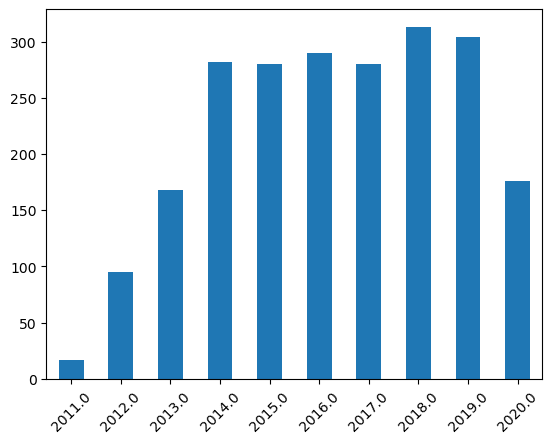

In [196]:
year_counts = df.launch_announced.value_counts().sort_index()

year_counts.plot(kind="bar", rot=45)
plt.show()


#### Misc price


<Axes: >

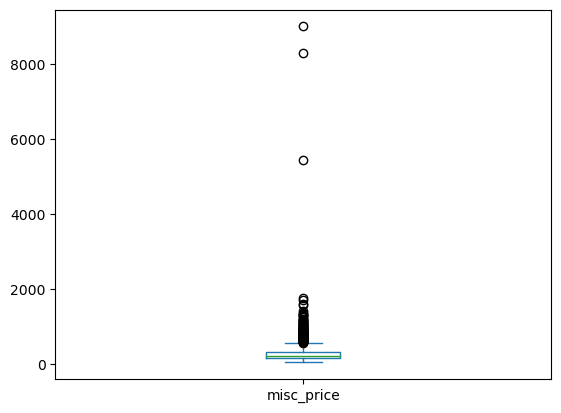

In [197]:
df.misc_price.plot.box(whis=1.5)


In [198]:
df.loc[df.misc_price > 1000, "misc_price"] = 1000


<Axes: >

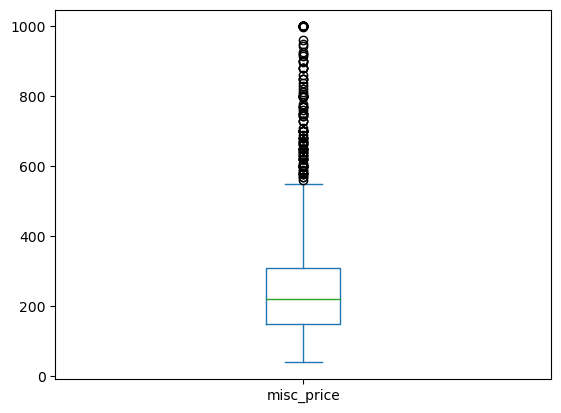

In [199]:
df.misc_price.plot.box(whis=1.5)


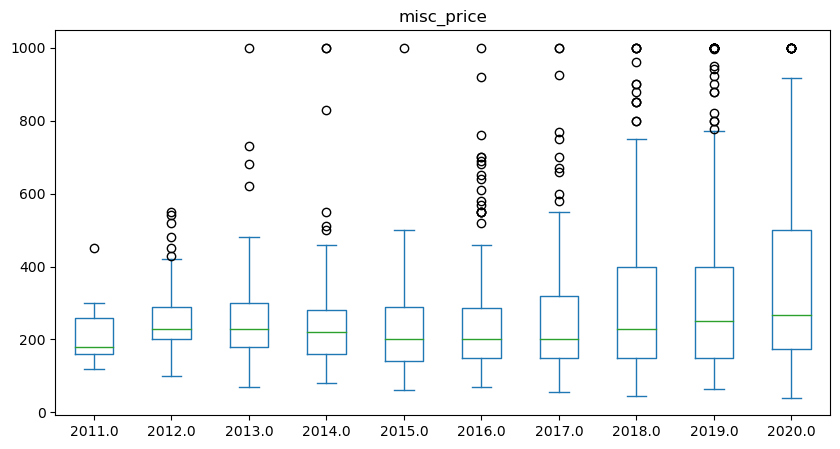

In [200]:
# show boxplot of misc_price for distinct launch_announced
df.plot.box(by="launch_announced", column="misc_price", figsize=(10, 5))
plt.show()


#### Display size


<Axes: xlabel='display_width', ylabel='display_height'>

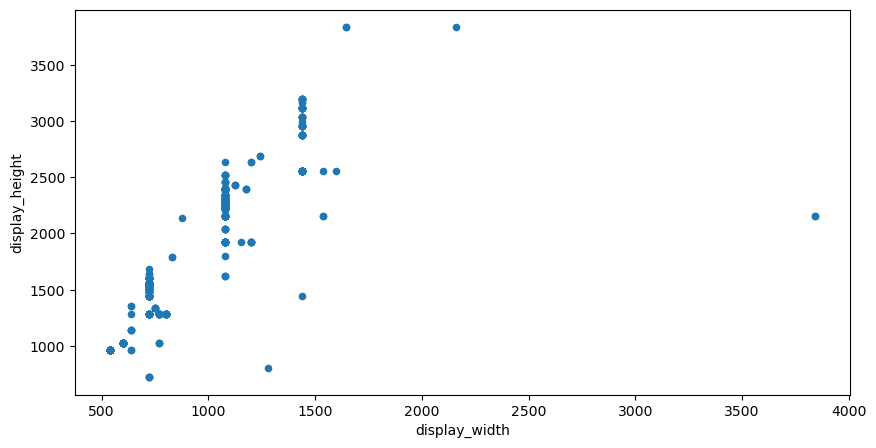

In [202]:
df.plot(kind="scatter", x="display_width", y="display_height", figsize=(10, 5))


Save the preprocessed dataset in a new csv file


In [210]:
out_path = os.path.join("data", "processed", ds_conf["name"])
df.to_csv(out_path, index=False)


### Plot of numerical feature correlations


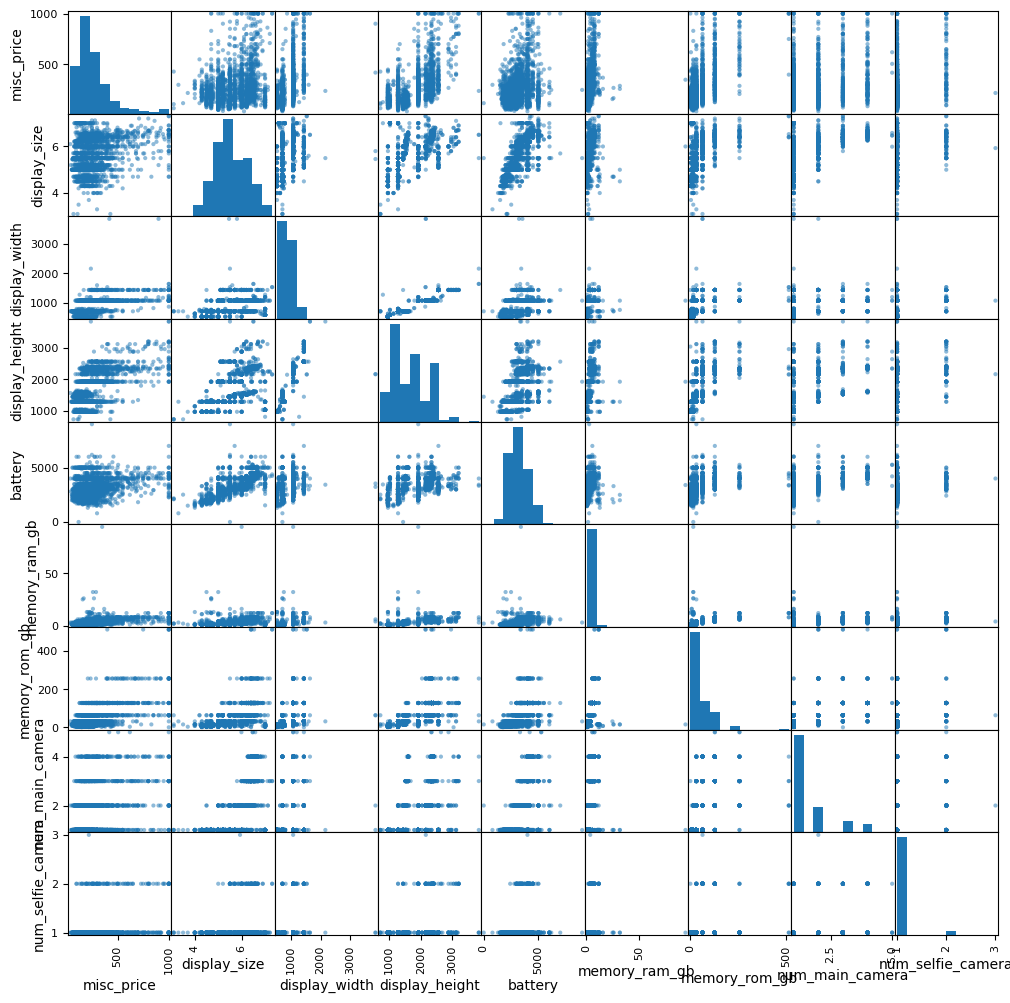

In [209]:
from pandas.plotting import scatter_matrix


attributes = [
    "misc_price",
    "display_size",
    "display_width",
    "display_height",
    "battery",
    "memory_ram_gb",
    "memory_rom_gb",
    "main_camera_resolution",
    "num_main_camera",
    "selfie_camera_resolution",
    "num_selfie_camera",
]
scatter_matrix(df[attributes], figsize=(12, 12))
plt.show()


### Correlation between data


In [215]:
df.corr(numeric_only=True)["misc_price"].sort_values(ascending=False)


misc_price               1.000000
memory_rom_gb            0.601073
display_height           0.595482
display_width            0.548772
has_oled_display         0.503945
has_wireless_charging    0.499889
has_wlan_5ghz            0.461080
has_nfc                  0.439080
memory_ram_gb            0.408230
is_waterproof            0.382199
has_stereo_speakers      0.381291
num_main_camera          0.360579
display_size             0.298718
num_selfie_camera        0.267992
battery                  0.262229
launch_announced         0.192252
has_memory_card_slot    -0.436761
has_3.5mm_jack          -0.525965
Name: misc_price, dtype: float64

Let's try to figure out if there are some correlations between the different features and we will try to perform an analysis to evaluate if it is worth to eventually delete some features.


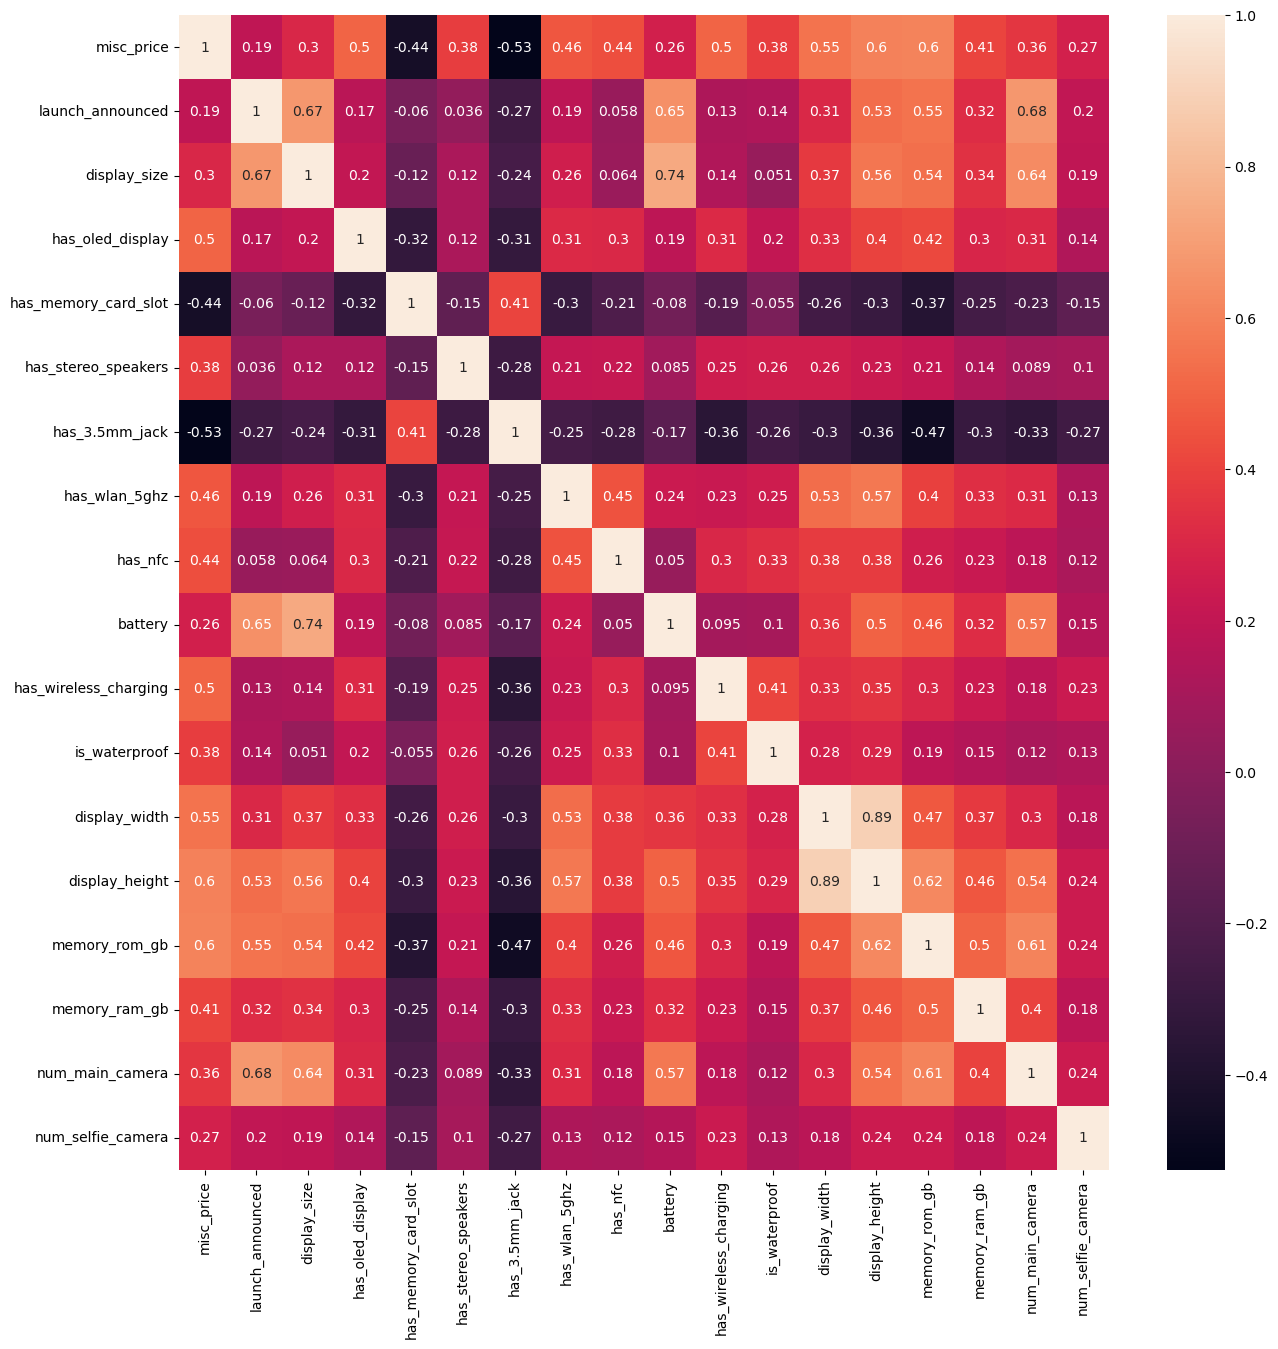

In [212]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()


In [216]:
df.describe()


,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,num_main_camera,num_selfie_camera
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,267.677965,2016.321542,5.570576,0.233560,0.822222,0.141497,0.920635,0.539683,0.393651,3180.175510,0.063492,0.128798,906.616327,1718.526077,47.082086,3.352027,1.522449,1.043991
std,174.290393,2.306094,0.690490,0.423191,0.382412,0.348612,0.270369,0.498536,0.488670,877.242773,0.243901,0.335052,256.090644,519.973986,55.012646,3.207697,0.889069,0.207322
min,40.000000,2011.000000,3.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,540.000000,720.000000,1.000000,1.000000,1.000000,1.000000
25%,150.000000,2014.000000,5.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2500.000000,0.000000,0.000000,720.000000,1280.000000,16.000000,2.000000,1.000000,1.000000
50%,220.000000,2016.000000,5.500000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3020.000000,0.000000,0.000000,750.000000,1560.000000,32.000000,3.000000,1.000000,1.000000
75%,310.000000,2018.000000,6.200000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4000.000000,0.000000,0.000000,1080.000000,2160.000000,64.000000,4.000000,2.000000,1.000000
max,1000.000000,2020.000000,7.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9000.000000,1.000000,1.000000,3840.000000,3840.000000,512.000000,94.000000,5.000000,3.000000


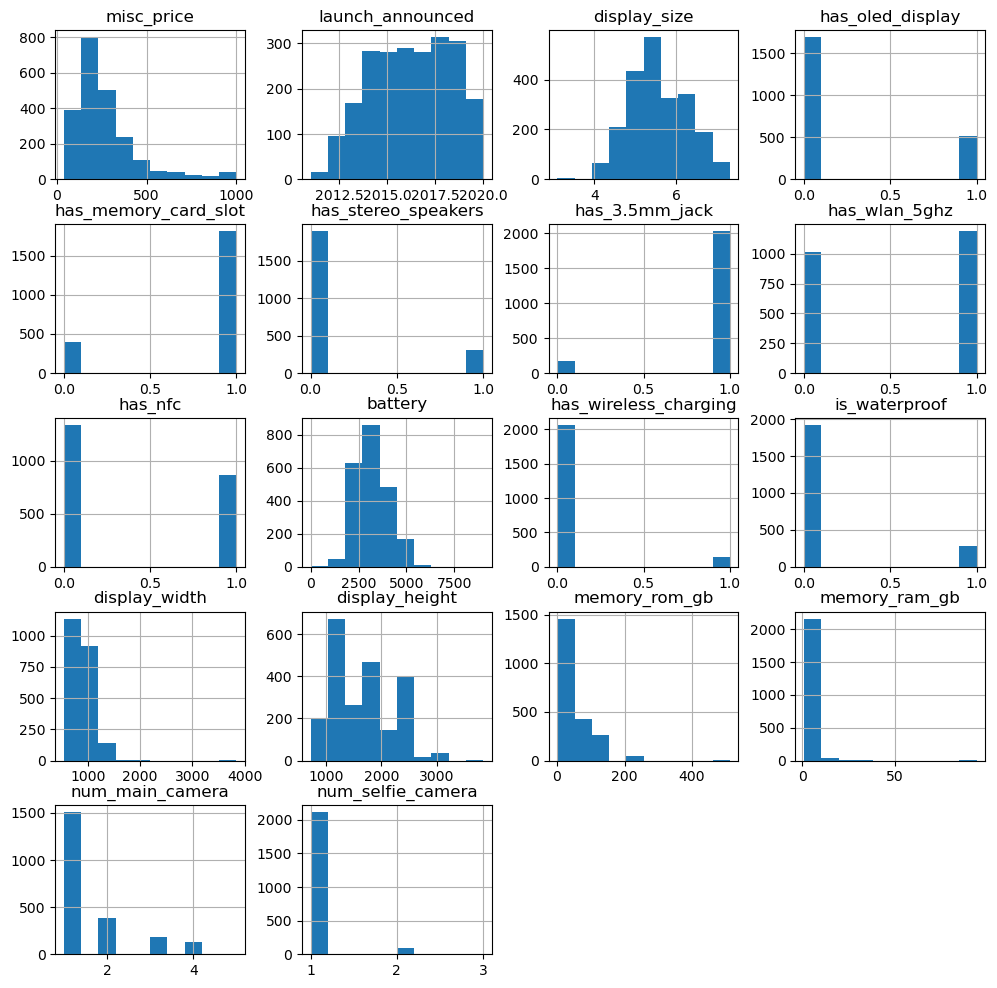

In [218]:
df.hist(figsize=(12, 12))
plt.show()
